# Использование предобученных трансформеров

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Большинство SOTA моделей последних лет основаны на 1 нейросетевой архитектуре, которая называется Transformer. Эта архитектура была представлена в 2017 году в статье - [Attention is all you need](https://arxiv.org/abs/1706.03762). 

На тот момент в обработке последовательностей доминировали рекуррентные нейроные сети, но у них была проблема с "забыванием" информации при обработке длинных текстов. Для решения этой проблемы был придуман механизм внимания (attention), который позволял на каждом шаге учитывать информацию от всех предыдущих и последующих элементов. LSTM+Attention некоторое время был sota подходом, но в attention is all you need было показано, что можно получить те же результаты, используя по сути только механизм внимания, без рекуррентности. 

Отсутствие рекуррентности позволяет гораздо эффективнее распараллеливать вычисления как на 1 gpu/tpu так и на кластере. На тот момент уже было несколько исследований показывающих, что при увеличении количества параметров и данных, модели начинают вести себя неожиданно хорошо (например, у OpenAI была статья в которой они рассказывали, что оставили LSTM на несколько месяцев и потом обнаружили, что она научилась достаточно точно определять тональность текста (без обучения на размеченном датасете) - https://openai.com/blog/unsupervised-sentiment-neuron/). Рекуррентные сети не позволяли серьезно увеличивать размер сетей даже при наличие ресурсов, а трансформеры позволили. 

Все последующие годы регулярно появлялись (и продолжают появляться) все более и более объемные трансформерные модели (BERT, GPT-1,2,3, Megatron). И каждый раз увеличение размера приводило к новым беспрецедентным результатам. 

Давайте попробуем чуть более подробно разобрать, как устроен трансформер. Это не простая тема и разбирать её мы будем постепенно.   
**В этом семинаре посмотрим в целом на архитектуру и ее ключевые элементы, а также попробуем использовать предобученные трансформерные модели для задачи классификации.**

## Seq2seq

Для начала вернемся к рекуррентным сетям. Их недостатки наиболее серьезно проявились в задаче seq2seq. В seq2seq по входной последовательности нужно сгенерировать целевую последовательность, а длины последовательностей при этом могут отличаться. Самый каноничный пример seq2seq задачи - машинный перевод.

Использование LSTM* для машинного перевода можно схематически представить вот так:

*_тут и далее когда я говорю LSTM я на самом деле подразумеваю рекуррентные нейроные сети в целом, просто LSTM самый популярный их представитель, но уточнять это каждый раз неудобно_

In [21]:
Image(url="https://i.ibb.co/XjP2Gmh/Lstm-seq2seq.png", width=700, height=500)

Для такой задачи нужно два LSTM слоя: один кодирует входную последовательность (encoder, или кодировщик), другой генерирует целевую последовательность (decoder или декодировщик). Такой подход работает, но есть серьезный недостаток - на вход декодеру подается только 1 вектор, в котором закодирована вся информация о целевой последовательности. Этот вектор - бутылочное горлышко (botleneck), узкое место, в которое все упирается.

Если приводить аналогии, это как пытаться первести текст сходу целиком, прочитав его только 1 раз (попробуйте, например, перевести это предложение, не перечитывая). 

### Attention

Для устранения бутылочного горлышка стали использовать механизм внимания. Он дает декодирующей LSTM доступ ко всем состояниям энкодера, а не только к последнему. Это уже больше похоже на то, как человек переводит текст - текст прочитывается целиком, но при переводе можно возвращаться к каждому отдельному слову исходного текста.   

Схематично LSTM+Attention можно представить вот так. Такая архитектура уже в середине десятых годов позволила Google начать переход к нейронному переводу (до этого использовался статистический и правиловый):

In [14]:
Image(url="https://i.ibb.co/bzwNqwC/lstm-attention-seq2seq.png",
     width=600, height=500)

Давайте подробнее посмотрим на механизм внимания. Визуализировать его целиком достаточно сложно, поэтому рассмотрим только 1 шаг (генерацию первого слова в переводе). 

In [19]:
Image(url="https://i.ibb.co/19xB94B/lstm-attention-1-step.png",
     width=700, height=600)

Само внимание (или attention) можно реализовать разными способами. Мы рассмотрим один возможный подход - через скалярное произведение. 

После прохода энкодера для каждого элемента входной последовательности существует вектор состояния (его можно считать контекстным эмбедингом слова). На каждом шаге декодера между текущим состоянием декодера и всеми состояними энкодера расчитывается скалярное произведение (можно сказать считается близость между переводным словом и всеми словами входного текста). Результатом такого скалярного произведения является набор весов, соответствующих каждому слову входной последовательности. Эти веса показывают, какие слова релеванты для генерации текущего слова в переводе. 

Далее каждый вес умножается на соотвутсвующий ему вектор состояния энкодера и эти вектора прибавляются к текущему состоянию декодера (то есть происходит взвешенная сумма векторов слов входной последовательности и итоговая сумма прибавляется или конкатенируется к состояние декодера). 

Attention убрал существующий bottleneck, но обучать такие модели было очень тяжело, так как в основе был LSTM. В 2017 был предложен подход без использования LSTM - Transformer.

## Transformer 

Вот как схематично решается задача машинного перевода с помощью трансформера. Самим трансформером называется блок с вниманием и полносвязными слоями, то есть и энкодер и декодер состоят из идентичных трансформерных блоков. Как и другие слои - трансформерные блоки можно накладывать друг на друга. Количество таких блоков в энкодере и декодере - настраиваемый гиперпараметр модели. 

In [3]:
Image(url="https://i.ibb.co/XY0GK2R/transformer.png", width=700, height=500)

В трансформерных блоках также есть нормализация и skip-связи, но пока мы их пропустим. 

Attention в трансформере конечно не такой простой как на примере выше. Давайте посмотрим на визуализацию из вот этого поста https://jalammar.github.io/illustrated-transformer/ (его имеет смысл почитать целиком)

Attention также вычисляется через скалаярное произведение, но оно считается не между векторами напрямую. 

Каждый эмбединг одтельного слова преобразуется в 3 отдельных вектора с помощью полносвязного слоя (умножения на матрицу). У них есть названия: query вектор, key вектор и value вектор. 

In [8]:
Image(url="https://jalammar.github.io/images/t/transformer_self_attention_vectors.png", width=400, height=400)

Attention score вычисляется с помощью скалярного произведения query вектора текущего слова и key векторов всех слов в последовательности. Результат скалярного произведения пропускается через softmax, чтобы получить вероятности (это и есть оценки внимания, attention scores, высокая вероятность означает, что на это слово нужно обратить внимание, а низкий - что слово на текущем шаге не важно). 

Далее выполняется взвешенная сумма всех value векторов (веса = attention скоры). Полученный вектор уже передается дальше в полносвязный слой. При наслаивании транформерных блоков друг на друга на втором слое вместо эмбединга слова уже будет использоваться вектор полученный из предыдущего блока.

In [9]:
Image(url="https://jalammar.github.io/images/t/self-attention-output.png", width=400, height=400)

Но это еще не все. Это пример того, что называется self-attention - когда внимание расчитыватся между элементами одной последовательности. На схеме выше еще есть cross-attention. Он используется в декодере - query вектор тут получается из эмбедингов слов в целевой последовательности, а key и value вектора получаются из выходных векторов энкодера. Cross-attention связывает энкодер и декодер.

Self-attention также присутствует в декодере. При обучении seq2seq моделей на вход подаются сразу две последовательности (текст и его перевод, например), но целевая последовательность подается постепенно (по 1 слову) и задача декодера - по полной входной последовательности и имеющейся на данный момент целевой последовательности сгенерировать продолжение. При использовании обученной модели для перевода текста сначала в декодер передается пустая последовательсть (а точнее не пустая а с тегом SOS или start, можно тут вспомнить семинар по языковым моделям).

#### Positional embedding

Еще одна важная составляющая транформера - positinal encoding (на схеме вместо обычного emded - pos emded), позиционной кодирование. Механизм внимания ничего не знает о позиции слов, он рассматривает последовательность как мешок слов, а от LSTM мы избавились. Поэтому нужно как-то закодировать информацию о последовательности в эмбединги слов. В Attention is all you need это было сделано простым добавлением к эмбедингу слова вектора, который зависит от индекса слова в последовательности. В статье они использовали периодичные функции (синус и косинус), которые не нужно обучать - они просто возвращают какое-то значение на каждый индекс последовательности. Количество уникальных векторов генерируемых таким образом конечно ограничено, но очень большое количество и не требуется, так как транформер сам по себе не очень хорошо масштабируется на длинные последовательности (обычно ограниченивают максимальную длину около 512).

Вот визуализация позиционных векторов из того же поста (изображено 20 векторов - по строкам, каждый размерности 512 - колонки; видно как вектора меняются при увеличении индекса):

In [13]:
Image(url="https://jalammar.github.io/images/t/transformer_positional_encoding_large_example.png", 
      width=700, height=500)


В трансформере еще много других технических деталей, но для использования пока будет достаточно интуитивного понимания.

## Использование предобученных моделей

С появлением предобученных трансформеных моделей развился transfer learning - это использование моделей для задач, решать которые они изначально не обучались. 

Большинство предобученных моделей - языковые модели, которые обучались просто продолжать текст или заполнять в нем пропуски. Эмбединги, которые генерирует энкодер таких предобученных моделей уже очень хорошо улавливают смысл и их можно напрямую использовать для классифицикаии. А можно еще немного дообучить весь энкодер на доступных размеченных данных и получить еще лучший результат. Так как в модели уже много знаний, для дообучения нужно буквально несколько примеров. 

Давайте посмотрим на разницу в качестве дообученной модели и обученной с нуля на имеющихся данных.

In [1]:
# !pip install sklearn pandas matplotlib transformers

In [1]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer


Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [2]:
# data_frac = pd.concat([data[data.topic=='Россия'].sample(frac=0.001),
#                       data[data.topic=='Мир'].sample(frac=0.001),
#                       data[data.topic=='Экономика'].sample(frac=0.002),
#                       data[data.topic=='Спорт'].sample(frac=0.003),
#                       data[data.topic=='Наука и техника'].sample(frac=0.005),
#                       data[data.topic=='Бывший СССР'].sample(frac=0.005),
#                       data[data.topic=='Культура'].sample(frac=0.005),
#                       data[data.topic=='Интернет и СМИ'].sample(frac=0.005),
#                       data[data.topic=='Из жизни'].sample(frac=0.01),
#                       data[data.topic=='Дом'].sample(frac=0.01),
#                       data[data.topic=='Силовые структуры'].sample(frac=0.01),
#                       data[data.topic=='Ценности'].sample(frac=0.03),
#                       data[data.topic=='Бизнес'].sample(frac=0.03),
#                       data[data.topic=='69-я параллель'].sample(frac=0.05),
#                       data[data.topic=='Крым'].sample(frac=0.05),
#                       data[data.topic=='Культпросвет'].sample(frac=0.2),
#                       data[data.topic=='Легпром'].sample(frac=0.8),
#                       data[data.topic=='Библиотека']]).reset_index(drop=True)

In [3]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [4]:
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

In [5]:
data.shape

(607, 6)

### Загружаем предобученную модель из huggingface transformers

Список всех доступных моделей можно найти тут - https://huggingface.co/models  
А вот тут основные с описанием - https://huggingface.co/transformers/pretrained_models.html

На HG предпочитают торч, поэтому многие модели не загрузятся в тф. Там есть специальный тэг, по которому можно фильтровать модели. 

Виды моделей мы обсудим на следующем занятии, так как их очень много и они существенно отличаются друг от друга. Пока разберем 3 варианта одной из первых предобученных моделей - BERT. 

In [6]:
# # Можно сказать оригинальный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# model_bert = AutoModel.from_pretrained('bert-base-cased')

In [7]:
# # # # Мультиязычный берт
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-uncased')

2022-03-02 13:24:35.316372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 13:24:35.319534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 13:24:35.319920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 13:24:35.320426: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# # # # Rubert который есть на тф от неизвестного пользователя геотренд
# tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
# model_bert = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased")

Мы загружаем не только модель, а еще и токенайзер, т.е. свою предобработку нам писать не нужно

In [9]:
data.loc[4, 'title']

'По факту пожара на\xa0заводе в\xa0Югре заведено дело'

Перевести токены в индексы очень просто

In [10]:
tokenizer.encode(data.loc[4, 'title'])

[101,
 10291,
 56538,
 10236,
 10291,
 55974,
 10185,
 10124,
 65784,
 309,
 37873,
 14608,
 10242,
 56615,
 26069,
 102]

В этих моделях как правило используется BPE

In [11]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'по',
 'факт',
 '##у',
 'по',
 '##жар',
 '##а',
 'на',
 'заводе',
 'в',
 'юг',
 '##ре',
 'за',
 '##ведено',
 'дело',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [12]:
text = data.loc[4, 'title']
text_ids = tf.constant([tokenizer.encode(text, add_special_tokens=True)])
output = model_bert(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов. 

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [13]:
output[0].shape # в пайторче вместо .shape используется size()

TensorShape([1, 16, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [14]:
output[1].shape

TensorShape([1, 768])

Обычно в задачах используют либо состояние первого элемента

In [15]:
output[0][:,0].shape

TensorShape([1, 768])

Либо усредненное состояние 

In [16]:
tf.math.reduce_mean(output[0], axis=1).shape

TensorShape([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

Будем обучаться на заголовках, а не на самих текстах

In [17]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

In [18]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [19]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [20]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [21]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [22]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

Загруженную модель в tf.keras можно использовать просто как слой в нейронной сети. Давайте сделаем новую модель, которая будет принимать на вход индексы символьных нграмм, пропускать их через берт, и затем брать первый вектор из энкодера и классифицировать его.

У нас есть два варианты дообучения - обучать только последний классификатор, не трогая берт, либо обучать все целиком, используя предобученной состояние энкодера как отправную точку.

#### Дообучение с замораживанием предобученной модели

In [104]:
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-uncased', trainable=False)

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [105]:

input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})

# добавим дропаут чтобы не переобучалось
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) # [0][:, 0] - означает что мы берем первое 
                                                     # состояние у всех текстов в батче
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(tf.optimizers.Adam(learning_rate=2e-3), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




С батчсайзом тут приходится уже быть осторожным, т.к. берт занимает очень много места на видеокарте. 

In [106]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=20,
         epochs=20)

Epoch 1/20
29/29 [==============================] - 14s 303ms/step - loss: 2.8849 - accuracy: 0.0816 - rec_prec: 0.0000e+00 - val_loss: 2.7325 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 7s 255ms/step - loss: 2.8319 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.7668 - val_accuracy: 0.0323 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 7s 255ms/step - loss: 2.8210 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.7403 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 7s 255ms/step - loss: 2.7993 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.7685 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 7s 255ms/step - loss: 2.8160 - accuracy: 0.0764 - rec_prec: 0.0017 - val_loss: 2.7251 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 [=========================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


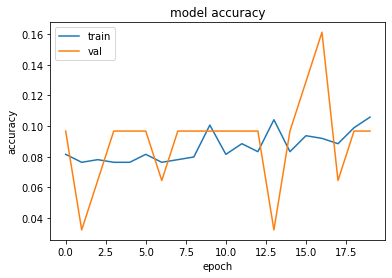

In [108]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [109]:
from sklearn.metrics import classification_report

In [111]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)

In [112]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

  Наука и техника       0.00      0.00      0.00         3
         Культура       0.00      0.00      0.00         3
         Ценности       0.00      0.00      0.00         2
      Бывший СССР       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
        Экономика       0.00      0.00      0.00         2
         Из жизни       0.10      1.00      0.18         3
           Бизнес       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
              Дом       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
   Интернет и СМИ       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
   69-я параллель       0.00      0.00      0.00       

Дообучение с замораживанием может не работать, давайте попробуем обучать все сразу

#### Дообучение без замораживания 

In [23]:
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-uncased', trainable=True)

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:

input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




Батч сайз нужно поставить еще меньше

In [25]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)

Epoch 1/20
288/288 [==============================] - 31s 92ms/step - loss: 2.8437 - accuracy: 0.0851 - rec_prec: 0.0000e+00 - val_loss: 2.7307 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 25s 88ms/step - loss: 2.7791 - accuracy: 0.0885 - rec_prec: 0.0000e+00 - val_loss: 2.7410 - val_accuracy: 0.1613 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 25s 88ms/step - loss: 2.7786 - accuracy: 0.0677 - rec_prec: 0.0000e+00 - val_loss: 2.7184 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 25s 88ms/step - loss: 2.7647 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.6952 - val_accuracy: 0.1935 - val_rec_prec: 0.0323
Epoch 5/20
288/288 [==============================] - 25s 88ms/step - loss: 2.7431 - accuracy: 0.0990 - rec_prec: 0.0017 - val_loss: 2.6651 - val_accuracy: 0.1613 - val_rec_prec: 0.0323
Epoch 6/20
288/288 [======================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


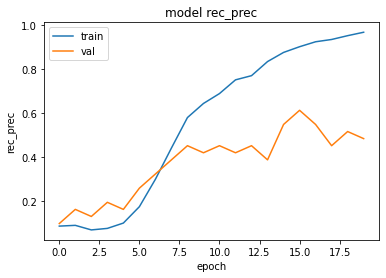

In [26]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import classification_report

In [29]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

In [30]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

Силовые структуры       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
      Бывший СССР       1.00      0.33      0.50         3
   Интернет и СМИ       0.00      0.00      0.00         2
         Ценности       0.50      1.00      0.67         2
          Легпром       0.00      0.00      0.00         1
  Наука и техника       1.00      0.33      0.50         3
              Мир       0.00      0.00      0.00         1
         Культура       1.00      1.00      1.00         3
              Дом       0.67      1.00      0.80         2
           Бизнес       0.25      0.50      0.33         2
         Из жизни       0.25      0.33      0.29         3
            Спорт       1.00      0.50      0.67         2
   69-я параллель       0.50      1.00      0.67         1
           Россия       0.50      1.00      0.67         2
             Крым       0.00      0.00      0.00       

Ф-мера выглядит не очень, но нужно помнить, что мы обучились на 600 примерах. Для сравнения можно попробовать обучить лстм на тех же данных.

In [31]:

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

for text in data.title:
    vocab.update(preprocess(text))

# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.title:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)


# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=MAX_LEN)


id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=data.topic)

In [41]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [42]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 13, 30)            93060     
                                                                 
 lstm_2 (LSTM)               (None, 128)               81408     
                                                                 
 dense_3 (Dense)             (None, 17)                2193      
                                                                 
Total params: 176,661
Trainable params: 176,661
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
18/18 [==============================] - 1s 14ms/step - loss: 2.8162 - accuracy: 0.0729 - val_loss: 2.7711 - val_accuracy: 0.0968
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 2.7351 - accuracy: 0.0642 - val_loss: 2.6892 - val_accuracy: 0.0968
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 2.6613 - accuracy: 0.0851 - val_loss: 2.6483 - val_accuracy: 0.0968
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 2.3986 - accuracy: 0.1128 - val_loss: 2.5514 - val_accuracy: 0.1613
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 2.2006 - accuracy: 0.1458 - val_loss: 2.6177 - val_accuracy: 0.1290
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 2.0251 - accuracy: 0.2049 - val_loss: 2.7911 - val_accuracy: 0.0968
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 1.8497 - accuracy: 0.2917 - val_loss: 3.2586 - val_accuracy: 0.1613
Epoch 8/50
18/18 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


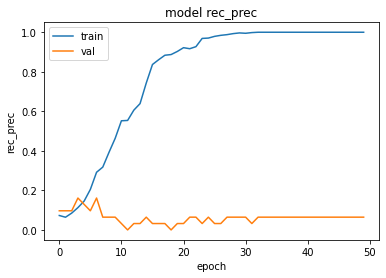

In [44]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
pred = model.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

Силовые структуры       0.00      0.00      0.00         2
        Экономика       0.25      0.50      0.33         2
      Бывший СССР       0.00      0.00      0.00         3
   Интернет и СМИ       0.00      0.00      0.00         2
         Ценности       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
  Наука и техника       0.00      0.00      0.00         3
              Мир       0.00      0.00      0.00         1
         Культура       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
           Бизнес       0.08      0.50      0.14         2
         Из жизни       0.00      0.00      0.00         3
            Спорт       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00       

Модель очень сильно переобучается. Она полностью выучивает обучающую выборку, но с предсказанием новых данных все очень плохо (разрыв в качестве с предобученной моделью огромный). Увеличение количества параметров не поможет - будет точно такая же картина. Для того, чтобы увеличить качество необходимо больше данных. 